# Vehicle detection¶
Self Driving Car Nanodegree 
By Nicholas Johnson 

<h2> Vehicle Detection and Tracking Project</h2> 
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
 


#### Import libraries

In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
import pickle
import multiprocessing as mp
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

#### Define image processing functions

In [55]:
# Spatial binning of image to reduce feature vector size
def bin_spatial(img, size=(32, 32)):
    #Use inter-area interpolation to improve quality of down-sampled image
    features = cv2.resize(img, size, interpolation=cv2.INTER_AREA).ravel()
    #print("Spatial features shape is:", features.shape)
    return features

#Compute color histograms for image
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #print("Hist features shape is:", hist_features.shape)
    return hist_features

def BGR2RGB(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #print("BGR2RGB max is:", np.max(img))
    return img

#Compute hog features for image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, block_norm='L1', 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, block_norm='L1', 
                       visualise=vis, feature_vector=feature_vec)
        #print("Hog features shape is:", features.shape)
        return features
    
#Extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = BGR2RGB(image)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    draw_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (100,255,0), 3)
    # Return the image
    return draw_img

def find_cars(img, x_start_stop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins):
    
    # make a heatmap of zeros 
    #heatmap = np.zeros_like(img[:,:,0])
    #img = img.astype(np.float32)/255
    draw_img = np.copy(img)     #create a copy of an image to draw on 
    img_tosearch = img[ystart:ystop, x_start_stop[0]:x_start_stop[1], :]
   
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step (2 originally)
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print("Hog features shape is:", hog_features.shape)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((x_start_stop[0]+xbox_left, ytop_draw+ystart),(x_start_stop[0]+xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            #print('Converting to YCrCb')
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image 
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image From Lectures 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function for plotting multiple images 
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims <= 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[1])
        else:
            plt.imshow(img)
            plt.title(titles[1])
            

#### Define ImageProcess Class

In [43]:
class vehicleprocessing: 
    
    def __init__(self, SVC, Scaler):
        
        self.smooth_count = 5 # Number of frames to average over
        self.threshold = 5 #threshold for detection
        self.Scaler = Scaler
        self.SVC = SVC
        self.window_scale = (1.25, 1.5625, 1.875)
        self.x_start_stop = [400, 1280] 
        self.y_start_stop = [[400, 520], [400, 580], [400, 700]]
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.spatial_size = (32, 32) # Spatial binning dimensions
        self.hist_bins = 32    # Number of histogram bins
        self.heatmaps_list = deque(maxlen=self.smooth_count)
        
    def __sum_heatmap(self, heatmaps_list, thresh):
        smooth_heatmap = 0
        #Sum the hot pixel values in the heatmap upto a maximum of smooth_count
        for i in range(len(heatmaps_list)):
            smooth_heatmap += heatmaps_list[i]
        #Apply the threshold before returning the heatmap
        return apply_threshold(smooth_heatmap, thresh)
    
        
    def vehicle_detection(self, img):
       
        detection_windows = []
        detection_rectangles = [] #Used only for cv2.groupRectangles
        hot_windows = [] #Used only for cv2.groupRectangles
        
        for i, scale in enumerate(self.window_scale):
            detection_windows.extend(find_cars(img, self.x_start_stop, self.y_start_stop[i][0], self.y_start_stop[i][1], 
                                               scale, self.SVC, self.Scaler, self.orient, self.pix_per_cell, 
                                               self.cell_per_block, self.spatial_size, self.hist_bins))

        #Run the pipeline using heatmaps
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap ,detection_windows)
        
        #####Use for running on images####
        #heatmap = apply_threshold(heatmap, self.threshold)
        #labels = label(heatmap)

        ###Use for running on videos####
        self.heatmaps_list.append(heatmap)
        smooth_heatmap = self.__sum_heatmap(self.heatmaps_list, self.threshold)
        labels = label(smooth_heatmap)
        
        ##Draw labels or detection windows
        final_img = draw_labeled_bboxes(img, labels)
        final_img = draw_boxes(img, detection_windows)
        #Comment out this line to run the pipeline using heatmaps

        
        #Comment out this line to run the pipeline using cv2.GroupRectangles
        ##Use cv2.Group rectangles
        groupThresh = 1
        eps = 1
        
        if detection_windows:
            for win in detection_windows:
                x = (win[1][0] + win[0][0])/2
                y = (win[1][1] + win[0][1])/2
                w = win[1][0] - win[0][0]
                h = win[1][1] - win[0][1]
                detection_rectangles.append((x,y,w,h))
    
        hot_rectangles = cv2.groupRectangles(detection_rectangles, groupThresh, eps)
    
        if any(map(len, hot_rectangles)):
            for rect in hot_rectangles[0]:
                hot_windows.append(((rect[0]-(rect[2]//2), rect[1]-(rect[3]//2)),  
                                     (rect[0]+(rect[2]//2), rect[1]+(rect[3]//2))))
        
        final_img = draw_boxes(img, hot_windows, color = (100,255,0))
        #Comment out this line to run the pipeline using cv2.GroupRectangles

        return final_img

## Build & train the classifer

Process the data

### Read in all the data

In [44]:
notcars = glob.glob('../non-vehicles/**/*.png', recursive=True)
cars = glob.glob('../vehicles/**/*.png', recursive=True)
test_image = cv2.imread(cars[0])
test_image = BGR2RGB(test_image)

print("Number of car images:", len(cars))
print("Number of background images:", len(notcars))
print("Image size for the data set is:", test_image.shape)
print("Total number of samples is:", len(cars) + len(notcars))

Number of car images: 8792
Number of background images: 8968
Image size for the data set is: (64, 64, 3)
Total number of samples is: 17760


### viseralize different HOG features of cars and notcars 

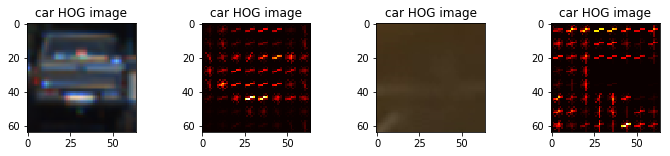

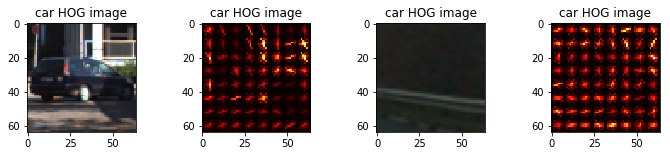

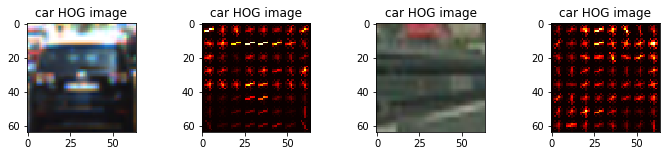

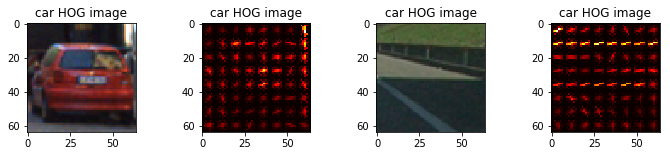

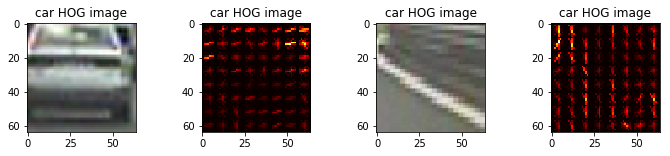

In [48]:
for x in range(0, 5):
    # choose random car / not car indices 
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # read in cars & notcars images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # define features parameters 
    color_space = 'YUV' #can be RGB, HSV, LUV, HLS, YUV. YCrCb 
    orient = 9 
    pix_per_cell = 8
    cell_per_block = 2 
    hog_channel = 2 # Can be 0,1, 2, or "ALL"
    spatial_size = (32, 32) #spatial binning dimensions 
    hist_bins = 32 # number of histogram bins 
    spatial_feat = True # spatial features on or off
    hist_feat = True # histogram features on or off 
    hog_feat = True # HOG features on or off 


    car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                                                      hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                      spatial_feat=spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat, vis=True)  

    notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                                                      hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                      spatial_feat=spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat,vis=True) 

    images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
    titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
    fig = plt.figure(figsize=(12,2)) #, dpi=80) 
    visualize(fig, 1, 4, images, titles)

### Define the variables

In [46]:
#Variables for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

### Convert the images to feature vectors and normalize the feature vectors

In [47]:
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Make sure the train/test splits are balanced
train_cars_percentage = len(y_train[y_train == 1])/len(y_train) * 100
train_notcars_percentage = 100 - train_cars_percentage
test_cars_percentage = len(y_test[y_test == 1])/len(y_test) * 100
test_notcars_percentage = 100 - test_cars_percentage

print("Training split size is {:d} samples".format(y_train.shape[0]))
print("Testing split size is {:d} samples".format(y_test.shape[0]))
print("Percentages of cars/notcars samples in the training split is {:.2f}% / {:.2f}%:"
      .format(train_cars_percentage, train_notcars_percentage))
print("Percentages of cars/notcars samples in the test split is {:.2f}% / {:.2f}%:"
      .format(test_cars_percentage, test_notcars_percentage))
print("Feature vector length is:", len(X_train[0]))

60.31 Seconds to extract features...
Training split size is 14208 samples
Testing split size is 3552 samples
Percentages of cars/notcars samples in the training split is 49.53% / 50.47%:
Percentages of cars/notcars samples in the test split is 49.41% / 50.59%:
Feature vector length is: 8460


### Shuffle the data and segment into training and test splits

##### Initalize & train the classifier

In [49]:
# Use a linear SVC 
svc = LinearSVC(random_state=0, loss='hinge') # Use a linear SVC 
# Check the training time for the SVC
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


2.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


### Perform predictions using the vehicleprocessing Class

#### Load the classifier and scaler using pickle

In [50]:
with open('./models/SVM.pkl', 'rb') as fid:
    svc, X_scaler = pickle.load(fid)

#### Read in all the test images

Test images shape is: (6, 720, 1280, 3)


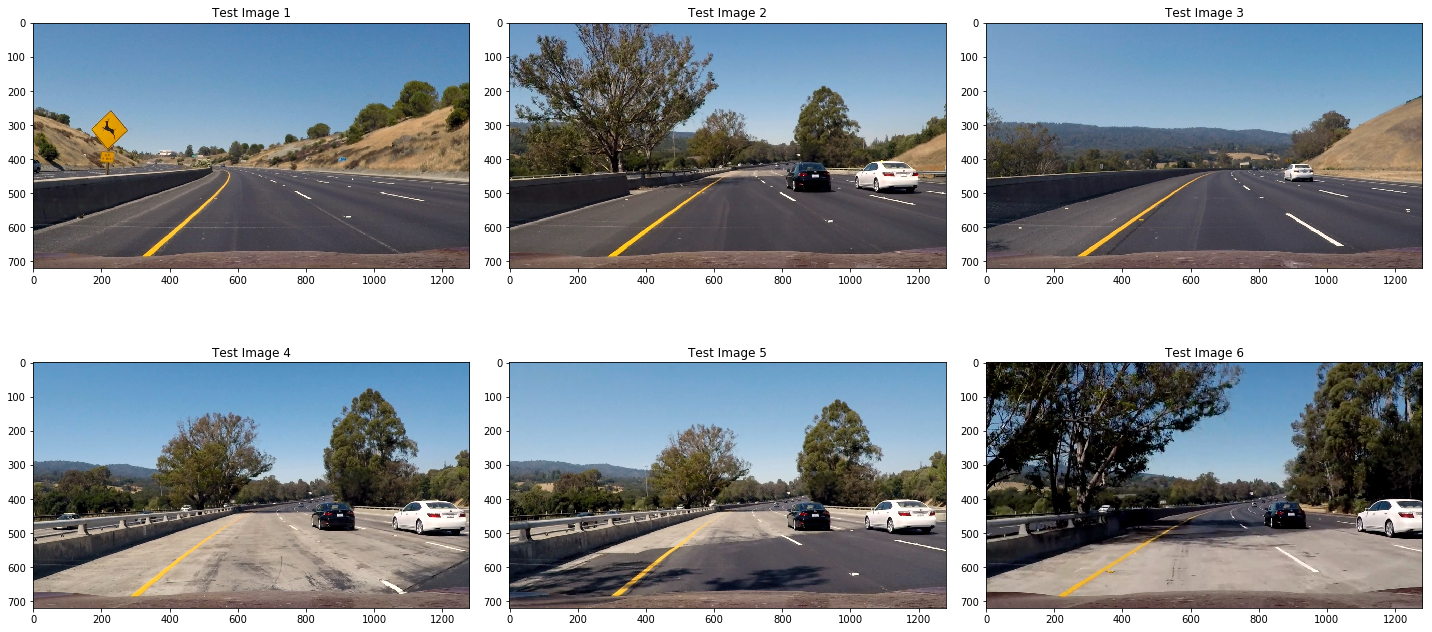

In [51]:
test_files = glob.glob('./test_images/*.jpg')
test_images = []
#Use cv2.imread() to read files so that all files are scaled from 0-255
for file in test_files:
    test_image = cv2.imread(file)
    test_image = BGR2RGB(test_image)
    test_images.append(test_image)

test_images = np.asarray(test_images)
print("Test images shape is:", test_images.shape)

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20,10))
for idx, image in enumerate(test_images):
    plt.subplot(nrows,ncols, idx+1)
    plt.imshow(test_images[idx])
    plt.title("Test Image {:d}".format(idx+1))
fig.tight_layout()
plt.show()

#### Visualize & search the windows

Visualize the windows on each test image

Total # of windows: 412


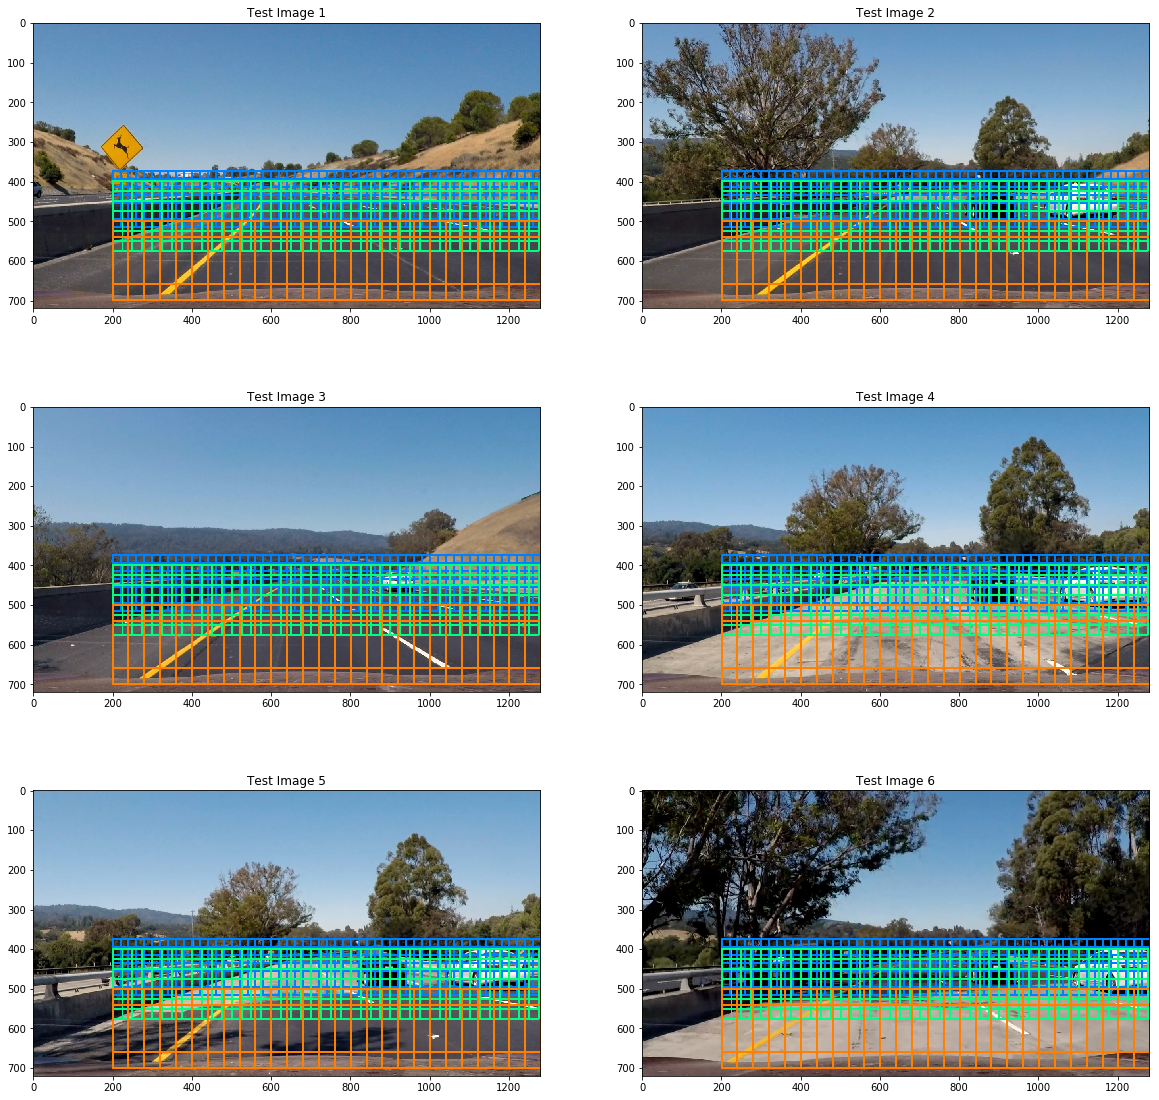

In [35]:
#Variables for sliding windows
window_scale = (1.0, 1.25, 2)
x_start_stop = [200, 1280]
#y_start_stop = [[400, 500], [450, 600], [500, 700]]
y_start_stop = [[375, 520], [400, 580], [500, 700]]
xy_window = (80, 80)
xy_overlap = (0.75, 0.75)
color_values = [(0,128,255), (0,255,128), (255,128,0)]

plt.figure(figsize=(20,20))
for idx, image in enumerate(test_images):
    n_windows = 0
    for i, scale in enumerate(window_scale):
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop[i], 
                                    xy_window=[int(dim*window_scale[i]) for dim in xy_window], xy_overlap=xy_overlap)
        image = draw_boxes(image, windows, color_values[i])
        n_windows += len(windows)
    plt.subplot(3,2,idx+1)
    plt.imshow(image)
    plt.title("Test Image {:d}".format(idx+1))
#plt.savefig('.\\output_images\\SVM_windows.png')
print("Total # of windows:", n_windows)
plt.show()

In [52]:
#Define window scales for HOG subsampling to match windows displayed above
hogss_window_scale = ((window_scale[0]*80/64), (window_scale[1]*80/64), (window_scale[2]*80/64))

processor = vehicleprocessing(svc, X_scaler)
processor.window_scale = hogss_window_scale
processor.x_start_stop = x_start_stop
processor.y_start_stop = y_start_stop
processor.orient = orient 
processor.pix_per_cell = pix_per_cell
processor.cell_per_block = cell_per_block
processor.spatial_size = spatial_size
processor.hist_bins = hist_bins
processor.threshold = 1 #Use 1 for visualizing images, use 8 when running on video
processor.smooth_count = 10

Average Image processing time: 0.27 seconds


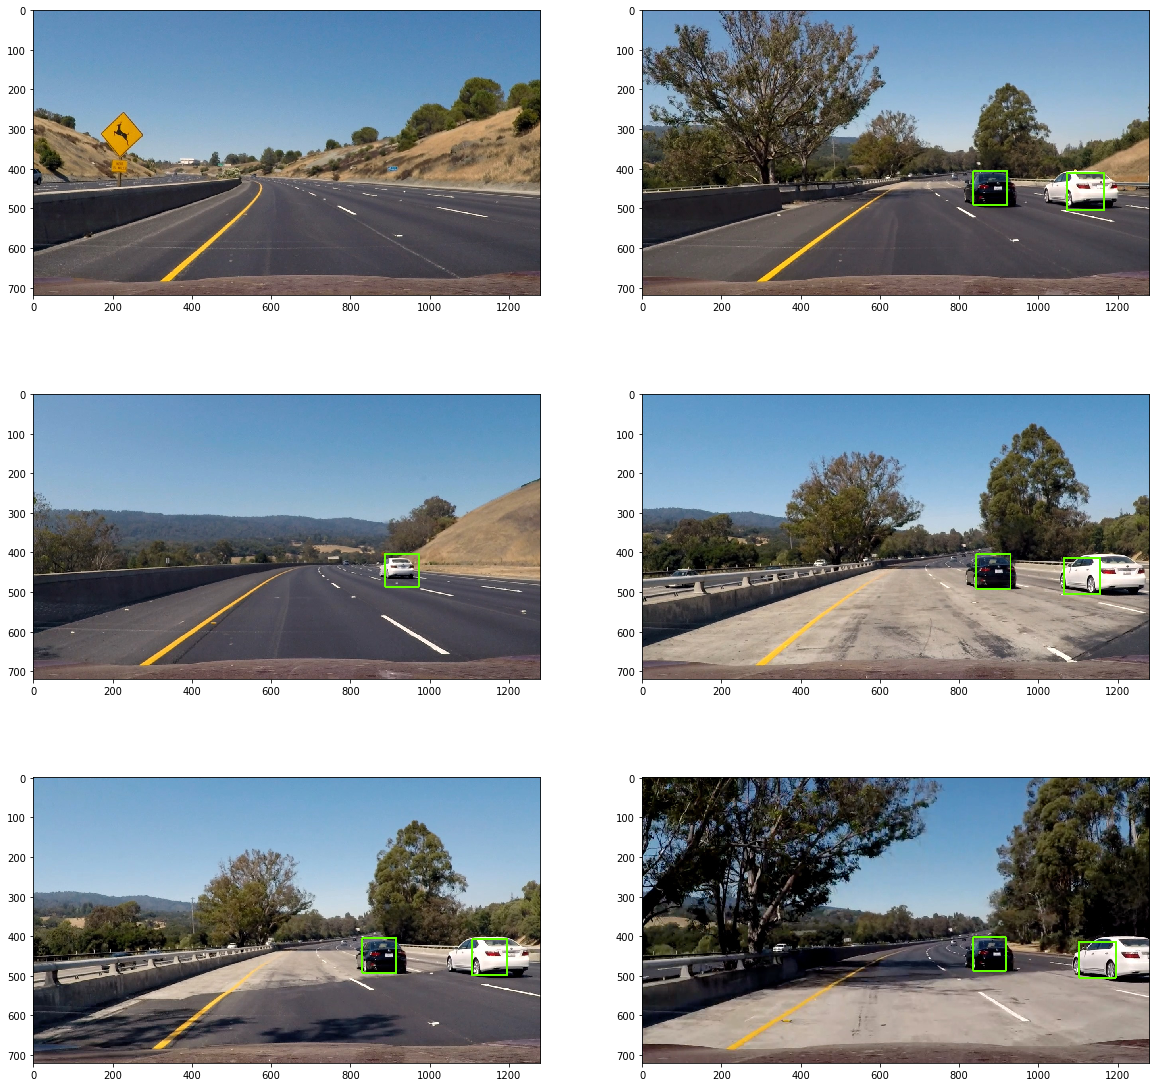

In [53]:
total_time= 0
plt.figure(figsize=(20,20))
for idx, image in enumerate(test_images):
    t = time.time()
    output_image = processor.vehicle_detection(image)
    t2 = time.time()
    total_time += round(t2-t,2)
    plt.subplot(3,2,idx+1)
    plt.imshow(output_image)
print("Average Image processing time: {:.2f} seconds".format(total_time/(idx+1)))
plt.show()

In [42]:
project_output = './output_videos/project_clip_out1.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(20,40)
#clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(processor.vehicle_detection)
%time clip.write_videofile(project_output, audio=False)
clip.reader.close()

[MoviePy] >>>> Building video ./output_videos/project_clip_out1.mp4
[MoviePy] Writing video ./output_videos/project_clip_out1.mp4


100%|█████████▉| 500/501 [02:29<00:00,  3.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_clip_out1.mp4 

CPU times: user 3min 8s, sys: 872 ms, total: 3min 9s
Wall time: 2min 30s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))